## Imports

In [1]:
# System imports
import sys
sys.path.append("/home/fscoreai/repos/fscoreai-ml/")

In [2]:
# Module imports
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# FscoreAI imports
from sample_data import sample_data

## Goal
Assume a dataset $\{\mathbf{X}, \mathbf{Y}\}$
$$
	\mathbf{X} = \begin{bmatrix}
	x^{(1)}_{1} & \dots & x^{(1)}_{d}\\
	\vdots & \ddots & \vdots \\
	x^{(n)}_{1} & \dots & x^{(n)}_{d}
	\end{bmatrix}
	\text{,}\qquad
	\mathbf{Y} = \begin{bmatrix}
	y^{(1)}\\
	\vdots\\
	y^{(n)}
	\end{bmatrix}
$$
where the discrete or continuous independent variable (also called the input, predictor, or covariate) $\mathbf{X} \in \mathbb{R}^{n\times d}$ and the continuous dependent variable (also called the output, target, label, or response variable) $\mathbf{Y} \in \mathbb{R}^{n\times 1}$, $n$ is the number of training examples and $d$ is the number of features. We wish to use a supervised learning approach for a regression application by learning a model hypothesis $h_\theta(\mathbf{x}^{(i)})$ which predicts $\hat y^{(i)}$ given $\mathbf{x}^{(i)}$, assuming the relationship between the two is linear.

In [7]:
# Create a sample linear data for demonstration purposes
num_samples = 1000
num_features = 2
X, Y = sample_data.simulate_multilinear_data(n=num_samples, d=num_features, seed=100)
print(X.shape, Y.shape)

(1000, 2) (1000, 1)


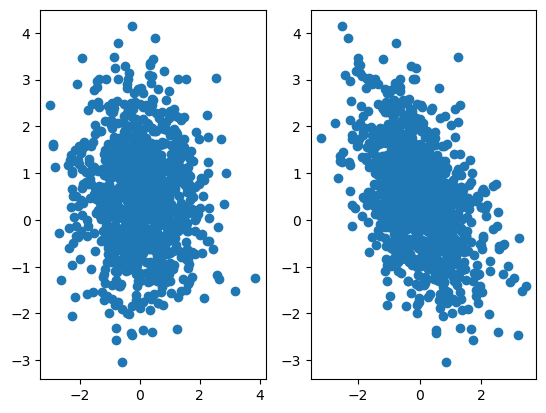

In [8]:
# Display sample data
fig, ax = plt.subplots(1,2)
ax[0].scatter(X[:,0], Y)
ax[1].scatter(X[:,1], Y)

## Model
Since the relationship between the input and the output is linear, we can use the following function to describe the model for the $i$-th example:
$$
	\boxed{h_\theta(\mathbf{x}^{(i)}) = \theta_0 + \theta_1 x^{(i)}_{1} + \dots + \theta_d x^{(i)}_{d} = \theta_0 + \sum_{j=1}^d\theta_j  x^{(i)}_{j}}
$$
where $i = (1,\dots,n)$, $j = (1,\dots,d)$, $\theta_0$ (a.k.a. bias or intercept) represents the average output when all $\mathbf{x}^{(i)} = 0$, $\theta_j$ (a.k.a. coefficient or slope) represents the average effect of one-unit increase of a certain feature $j$ on $y^{(i)}$. 

Note that the term $\theta_0$ makes the function affine.

Let's build a Linear Regression class that we will modify and improve as we go further.

In [9]:
class LinearRegression():
    def __init__(self):
        # Hard-coded default values
        self.coef_ = np.array([1, -1])
        self.intercept_ = 0
    
    def predict(self, X):
        num_samples, num_features = X.shape[0], X.shape[1]
        y_preds = []
        for sample in range(num_samples):
            y_pred = 0
            for feature in range(num_features):
                y_pred += self.coef_[feature] * X[sample, feature]
            y_preds.append(y_pred + self.intercept_)
        return np.array(y_preds).reshape(-1, 1)

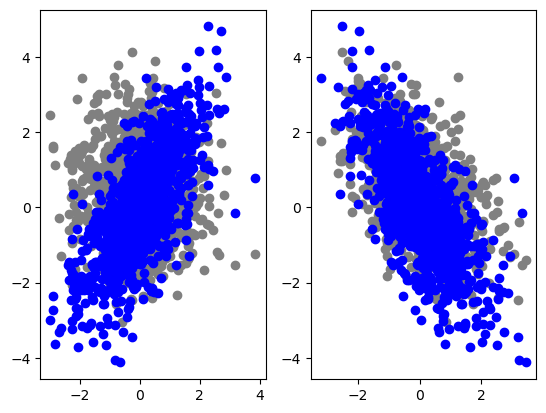

In [10]:
# Example
model = LinearRegression()
y_preds = model.predict(X)

fig, ax = plt.subplots(1,2)
ax[0].scatter(X[:,0], y, c="gray")
ax[0].scatter(X[:,0], y_preds, c="blue")

ax[1].scatter(X[:,1], y, c="gray")
ax[1].scatter(X[:,1], y_preds, c="blue")

## Loss Function
In order to quantify how well our model performs, we must define a function that compares the predicted output values $\hat y^{(i)}$ to the actual output values $y^{(i)}$. We will call such a function the "loss" function. One way to define the loss is to calculate the distance between the two values. Let's call this distance the "residual" $r^{(i)}$, where 
$$
r^{(i)} = y^{(i)} - \hat{y}^{(i)}
$$
We would like the residuals to be close to zero.

In [11]:
residuals = (y - y_preds)
residuals[:5]

array([[ 0.51143762],
       [-2.37217946],
       [-1.62427765],
       [ 0.70043804],
       [ 1.1397902 ]])

To quantify how well our model as a whole performs, let's find the average residuals over all our training examples, we shall call this function our "cost" function. We can do so by summing up the absolute values of our residuals and dividing the sum by the number of examples $n$. This method is called Mean Absolute Error (MAE). The caveat with using MAE is that absolute values are non-differentiable functions, which are not desirable for taking derivatives. We would eventually need to take derivatives for training this model. Instead, we can choose to average the sum of squared residuals. This will keep the function differentiable, with an added benefit of penalizing larger losses over smaller ones. This function is also called the Mean Squared Error (MSE) and is as follows:
$$
	\boxed{\mathcal{E} = \frac{1}{n}\sum_{i=1}^n{r^{(i)}}^2}
$$
Note: Dividing the sum of squared residuals by $n$ gives us a biased estimate of the variance of the unobserved errors. To remove the bias, divide the sum of squared residuals by $\mathrm{df} = n - d - 1$ where $\mathrm{df}$ is the degrees of freedom, and $d$ is the number of parameters being estimated (excluding the intercept).

In [12]:
def MSELoss(y, y_preds):
    residuals = (y - y_preds)**2
    return np.sum(residuals) / num_samples
print(MSELoss(y, y_preds))

2.582326889231361



## Training
Now that we have a model, along with a function to evaluate how well it performs, we would like to find the optimal values of our parameters $\theta$ that would minimize the cost. Fortunately, for linear regression problems, there is a direct, closed-form solution that we can employ (this is a very unique case). We will also take a look at optimizing our parameters using Gradient Descent and Maximum Likelihood Estimation.


### Direct Solution
Note: Recall from single variable calculus that (assuming a function is differentiable) the minimum $x^*$ of a function $f$ has the property that the derivative $\frac{\mathrm{d}f}{\mathrm{d}x}$ is zero at $x = x^*$. Note that the converse is not true: if $\frac{\mathrm{d}f}{\mathrm{d}x} = 0$, then $x^*$ might be a maximum or an inflection point, rather than a minimum. But the minimum can only occur at points that have derivative zero.

We will use this information to find the parameters that minimize our cost in the case of a univariate ($d = 1$) distributions. We can take the partial derivatives of the cost function with respect to the parameters $\theta_0$ and $\theta_1$, set the derivatives to zero, then solve for our estimated parameters $\hat\theta_0$ and $\hat\theta_1$.

**Taking the partial derivative w.r.t. $\hat\theta_0$**
\begin{align*}
	\frac{\delta\mathcal{E}}{\delta{\hat\theta_0}}&=\frac{\delta}{\delta{\hat\theta_0}}\frac{1}{n}\sum_{i=1}^n \left(y^{(i)} - \hat y^{(i)}\right)^2
    \\
    & = \frac{\delta}{\delta{\hat\theta_0}}\frac{1}{n}\sum_{i=1}^n \left[y^{(i)} - \left(\hat\theta_0 + \hat\theta_1 x^{(i)}\right)\right]^2
    \\
    & = \frac{-2}{n}\sum_{i=1}^n \left(y^{(i)} - \hat\theta_0 - \hat\theta_1 x^{(i)}\right)
    \\
    & = \frac{-2}{n}\left(\sum_{i=1}^ny^{(i)} - n\hat\theta_0-\hat\theta_1\sum_{i=1}^nx^{(i)}\right)
    \\
    & = -2\left(\frac{n}{n}\hat\theta_0+\hat\theta_1\frac{1}{n}\sum_{i=1}^nx^{(i)}-\frac{1}{n}\sum_{i=1}^ny^{(i)}\right)
    \\
    & = -2\left(\hat\theta_0+\hat\theta_1\bar x-\bar y\right)
\end{align*}

**Setting the partial derivative to 0 and solving for $\hat\theta_0$:**
\begin{align*}
	-2\left[\hat\theta_0+\hat\theta_1\bar x-\bar y\right] &= 0
    \\
    \hat\theta_0 &= \bar{y} - \hat\theta_1\bar{x}                      
\end{align*}

**Taking the partial derivative of $\hat\theta_1$:**
\begin{align*}
	\frac{\delta\mathcal{E}}{\delta{\hat\theta_1}} &= \frac{\delta}{\delta{\hat\theta_1}}\frac{1}{n}\sum_{i=1}^n \left(y^{(i)} - \hat y^{(i)}\right)^2
    \\
    & = \frac{\delta}{\delta{\hat\theta_1}}\frac{1}{n}\sum_{i=1}^n \left(y^{(i)} - \left(\hat\theta_0 + \hat\theta_1 x^{(i)}\right)\right)^2
    \\
    & = \frac{-2}{n}\sum_{i=1}^n (x^{(i)})\left(y^{(i)} - \hat\theta_0 - \hat\theta_1 x^{(i)}\right)
    \\
    & = \frac{-2}{n}\sum_{i=1}^n \left(x^{(i)}y^{(i)} - (\bar{y} - \hat\theta_1\bar{x}) x^{(i)}- \hat\theta_1 {x^{(i)}}^2\right)
    \\
    & = \frac{-2}{n}\left( \sum_{i=1}^n x^{(i)}y^{(i)} - \bar{y}\sum_{i=1}^nx^{(i)} + \hat\theta_1\bar{x}\sum_{i=1}^nx^{(i)}- \hat\theta_1 \sum_{i=1}^n{x^{(i)}}^2 \right)
\end{align*}

**Setting the partial derivative to 0 and solving for $\hat\theta_1$:**
\begin{align*}
    \left( -\sum_{i=1}^n x^{(i)}y^{(i)} + \bar{y}\sum_{i=1}^nx^{(i)} - \hat\theta_1\bar{x}\sum_{i=1}^nx^{(i)} +  \hat\theta_1 \sum_{i=1}^n{x^{(i)}}^2 \right) &= 0
\end{align*}
\begin{align*}
    \hat\theta_1 \left(\bar{x}\sum_{i=1}^nx^{(i)}-\sum_{i=1}^n{x^{(i)}}^2\right) &= \bar{y} \sum_{i=1}^nx^{(i)} - \sum_{i=1}^nx^{(i)}y^{(i)}
    \\
    \hat\theta_1 &= \frac{\bar{y} \sum_{i=1}^nx^{(i)} - \sum_{i=1}^nx^{(i)}y^{(i)}}{\bar{x}\sum_{i=1}^nx^{(i)}-\sum_{i=1}^n{x^{(i)}}^2}
    \\
    &= \frac{n\bar{y} \bar x - \sum_{i=1}^nx^{(i)}y^{(i)}}{n\bar{x}^2-\sum_{i=1}^n{x^{(i)}}^2}
    \\
    &= \frac{\sum_{i=1}^nx^{(i)}y^{(i)} - n\bar{y} \bar x}{\sum_{i=1}^n{x^{(i)}}^2 - n\bar{x}^2}
\end{align*}

**To simplify:**
\begin{align*}
\sum_{i=1}^nx^{(i)}y^{(i)} - n\bar{y} \bar x &= \sum_{i=1}^n(x^{(i)}-\bar x)(y^{(i)} - \bar{y}) := \mathrm{S_{XY}}
    \\
	\sum_{i=1}^n{x^{(i)}}^2 - n\bar{x}^2 & = \sum_{i=1}^n(x^{(i)} - \bar{x})^2 := \mathrm{S_{XX}}
    \\
	\hat\theta_1 &= \frac{\mathrm{S_{XY}}}{\mathrm{S_{XX}}}
    \\
    \hat\theta_0 &= \bar y - \frac{\mathrm{S_{XY}}}{\mathrm{S_{XX}}}\bar x
\end{align*}

We can expand this approach to multivariate training examples. To do so, we shall look at using a linear algebra approach to find a closed-form solution to linear regression.

https://www.stat.purdue.edu/~boli/stat512/lectures/topic3.pdf

(1000, 1) (1000, 1)


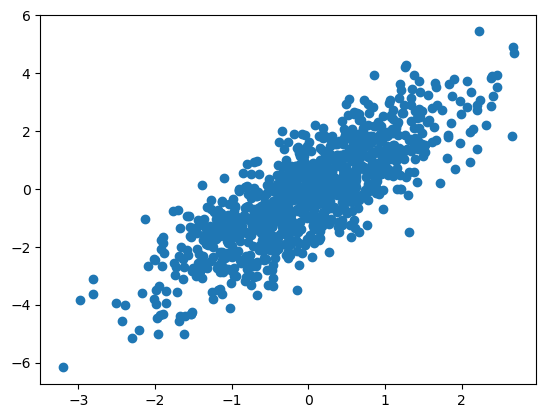

In [13]:
# Create a sample univariate linear data for demonstration purposes
num_samples = 1000
num_features = 1
X_uni, y_uni = sample_data.simulate_multilinear_data(n=num_samples, d=num_features, seed=10)
print(X_uni.shape, y_uni.shape)
plt.scatter(X_uni, y_uni)

In [14]:
class LinearRegression():
    def __init__(self):
        # Hard-coded default values
        self.coef_ = np.array([1, -1])
        self.intercept_ = 0
    
    def fit(self, X, y):
        num_samples = X.shape[0]
        X_mean = np.sum(X) / num_samples
        y_mean = np.sum(y) / num_samples
        S_XY = 0
        S_XX = 0
        for sample in range(num_samples):
            S_XY += (X[sample] - X_mean) * (y[sample] - y_mean)
            S_XX += (X[sample] - X_mean)**2
        self.intercept_ = y_mean - (S_XY / S_XX * X_mean)
        self.coef_ = S_XY / S_XX
    
    def predict(self, X):
        num_samples, num_features = X.shape[0], X.shape[1]
        y_preds = []
        for sample in range(num_samples):
            y_pred = 0
            for feature in range(num_features):
                y_pred += self.coef_[feature] * X[sample, feature]
            y_preds.append(y_pred + self.intercept_)
        return np.array(y_preds).reshape(-1, 1)

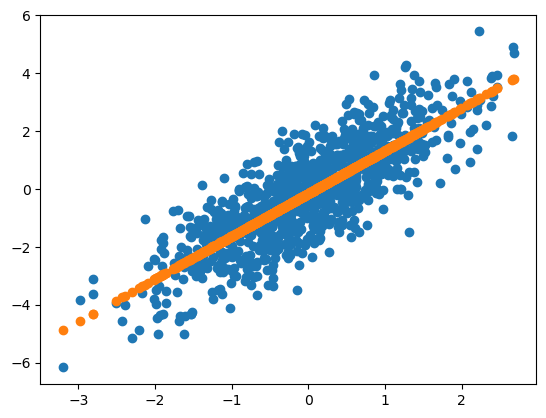

In [15]:
model = LinearRegression()
y_preds_uni = model.fit(X_uni, y_uni)
y_preds_uni = model.predict(X_uni)

plt.scatter(X_uni, y_uni)
plt.scatter(X_uni, y_preds_uni)

### Direct Solution (Vectorized)
To vectorize our closed-form solution for linear regression, let's rewrite our equations in matrix form. Before we can do that, we need to augment our design matrix to incorporate the bias term in the $\theta$ matrix:
$$
	\mathbf{X} = \begin{bmatrix}
	1 & x^{(1)}_{1} & \dots & x^{(1)}_{d}\\
	\vdots & \ddots & \vdots \\
	1 & x^{(n)}_{1} & \dots & x^{(n)}_{d}
	\end{bmatrix}
$$
where $\mathbf{X} \in \mathbb{R}^{n\times (d+1)}$

Notice that we have added a column of 1's in $\mathbf{X}$. Our $\theta$ matrix now looks like this:
$$
	\theta = \begin{bmatrix}
	\theta_0 & \dots & \theta_{d}\\
	\end{bmatrix}
$$
where $\theta \in \mathbb{R}^{d+1}$

Now we can revisit our hypothesis function which can be rewritten as the follows:
\begin{align}
    h(x^{(i)}) &= \sum_{j=0}^d\theta_j x_j^{(i)}
    \\
    h_\theta(x) &= \mathbf{X}\theta
\end{align}

Now our cost function can be rewritten as follows:
\begin{align*}
\mathcal{E}(\theta) &= \frac{1}{n}\sum_{i=1}^n({h_\theta(x^{(i)}) - y^{(i)}})^2
\\
&= \frac{1}{n}\sum_{i=1}^n({y_i - \mathbf{x}_i\theta})^2
\\
&= \frac{1}{n}(\theta^\top x^{(i)} - y^{(i)})^2
\\
&= \frac{1}{n}(\mathbf{X}\theta - y)^\top (\mathbf{X}\theta - y)
\end{align*}

Now we can take the partial derivative of the loss function with respect to $\theta$ abd set ut equal to zero to find the minima
\begin{align*}
\mathcal{E}(\theta) &= \frac{1}{n}(\mathbf{X}\theta - y)^\top(X\theta - y)
\\
&\propto \theta^\top X^\top X\theta - y^\top X\theta - \theta^\top X^\top y + y^\top y
\\
&\propto \theta^\top X^\top X\theta - 2\theta^\top X^\top y + y^\top y
\end{align*}
Take the derivative and set equal to 0, then solve for $\theta$:

\begin{align}
\frac{\delta}{\delta\theta}(\theta^\top X^\top X\theta - 2\theta^\top X^\top y + y^\top y) &= 0
\\
(X^\top X)\theta - X^\top y &= 0
\\
(X^\top X)\theta &= X^\top y
\\
\theta &= (X^\top X)^{-1}X^\top y
\end{align}

If $X^\top X$ is not invertible, you can use pseudo-inverse instead of the inverse by using `numpy.linalg.pinv(a)`. Also, make sure to remove redundant (non-linearly dependent) features, and maintain $d \le n$

In [16]:
# Vectorized
class LinearRegression():
    def __init__(self):
        # Hard-coded default values
        self.coef_ = np.array([1, -1])
        self.intercept_ = 0
        
    def fit(self, X, y):
        n, d = X.shape
        X = np.hstack((np.ones((n, 1)), X))
        self.weights_ = np.linalg.inv(X.T@X) @ (X.T@y)
        self.intercept_ = self.weights_[0]
        self.coef_ = self.weights_[1:]
        return
    
    def predict(self, X):
        num_samples, num_features = X.shape[0], X.shape[1]
        y_preds = []
        for sample in range(num_samples):
            y_pred = 0
            for feature in range(num_features):
                y_pred += self.coef_[feature] * X[sample, feature]
            y_preds.append(y_pred + self.intercept_)
        return np.array(y_preds).reshape(-1, 1)

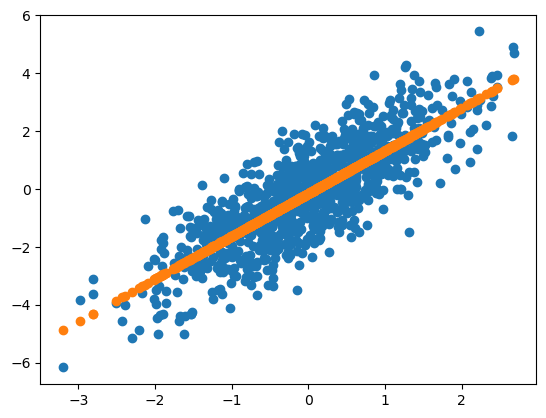

In [17]:
model = LinearRegression()
y_preds_uni = model.fit(X_uni, y_uni)
y_preds_uni = model.predict(X_uni)
plt.scatter(X_uni, y_uni)
plt.scatter(X_uni, y_preds_uni)

### Gradient Descent
Instead of a closed-form solution, we can use a more general approach to optimization called gradient descent. The basic algorithm of gradient descent is as follows:

1. Initialize all $\theta_j$ to some random values
2. Repeat until convergence:
    1. Choose a new value for $\theta_j$ toward the direction of steepest descent.
    2. Update for $j = (0, \dots, d)$

The gradient descent step is formulated by the following function:
$$\theta_j \leftarrow \theta_j - \alpha \frac{\delta}{\delta\theta_j}\mathcal{E}(\theta)$$
where $\alpha$ is an empirically-set learning rate.

For simplicity, we can continue our augmented design matrix where we have added a column of 1's in the inputs. Now, for each $j$:
\begin{aligned}
    \frac{\delta\mathcal{E}}{\delta\theta} & = \frac{\delta}{\delta\theta}\frac{1}{n}\sum_{i=1}^n \left(\hat y^{(i)} - y^{(i)}\right)^2
    \\
    & = \frac{2}{n}\sum_{i=1}^n (\hat y^{(i)} - y^{(i)}) \frac{\delta}{\delta \theta_j}(\theta x^{(i)} - y^{(i)})
    \\
    & = \frac{2}{n}\sum_{i=1}^n ((\hat y^{(i)} - y^{(i)})x^{(i)})
\end{aligned}
Therefore, for each $j$:
$$
	\theta_j \leftarrow \theta_j - \alpha \frac{2}{n}\sum_{i=1}^n ((\hat y^{(i)} - y^{(i)})x^{(i)})
$$

Repeat the above until convergence and update for $j = (0,1,\dots,d)$.
The above equation is also called batch gradient descent. "Batch" because all training examples are summed at every step. A disadvantage of this technique is that it is very computationally inefficient, especially for large datasets. To make gradient descent more optimized, we can alternatively use Stochastic Gradient Descent (SGD), which is noisy but eventually leads to the similar results as batch gradient descent. It is given as follows:
- Repeat:
    - For $i=1$ to $n$
    - $\theta_j \leftarrow \theta_j - \alpha \frac{\delta}{\delta\theta_j}\mathcal{E}(\theta)$
        
The above takes derivative of one example at a time. The gradient takes a bit more noisy approach toward minima and it never truly "converges".

Batch Gradient Descent and Stochastic Gradient Descent are two different optimization techniques used in training machine learning models, particularly in the context of iterative algorithms like gradient descent. The main difference between them lies in how they update the model's parameters using training data.

1. **Batch Gradient Descent**:
   - In Batch Gradient Descent, the entire training dataset is used to compute the gradient of the cost function at each iteration.
   - The algorithm calculates the average gradient over the entire dataset and updates the model's parameters in a single step.
   - This method tends to be stable and deterministic, but it can be computationally expensive for large datasets since it requires processing the entire dataset in each iteration.
   - The updates are more accurate since they consider a comprehensive view of the dataset.

2. **Stochastic Gradient Descent (SGD)**:
   - In Stochastic Gradient Descent, a single training example or a small subset (mini-batch) of the training data is used to compute the gradient at each iteration.
   - The algorithm performs more frequent updates to the model's parameters, often resulting in faster convergence.
   - Since each update is based on a single example or a small subset, the updates can be noisy and the optimization process may exhibit more variability.
   - Stochastic Gradient Descent can be more efficient for large datasets since it doesn't require processing the entire dataset in each iteration.

3. **Mini-Batch Gradient Descent**:
   - Mini-Batch Gradient Descent is a compromise between Batch and Stochastic Gradient Descent.
   - It uses a small randomly selected subset (mini-batch) of the training data to compute the gradient and update the model's parameters.
   - This approach combines some of the advantages of both Batch and Stochastic Gradient Descent: it's computationally efficient and also benefits from some level of noise that can help escape local minima.
   - Mini-batch size is a hyperparameter that can be tuned to achieve a balance between computation efficiency and optimization stability.

In summary, the main difference between Batch Gradient Descent and Stochastic Gradient Descent lies in the amount of training data used for computing the gradient at each iteration. Batch GD uses the entire dataset, while SGD uses one example or a small subset. The choice between them depends on factors such as the dataset size, computational resources, and optimization speed. Mini-Batch Gradient Descent is a popular choice that balances the benefits of both approaches.

In [ ]:
# Vectorized
class LinearRegression():
    def __init__(self):
        # Hard-coded default values
        self.coef_ = np.array([1, -1])
        self.intercept_ = 0
    
    def fit(self, X, y, lr, epochs):
        n, d = X.shape
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.weights_ = np.random.randn(d+1, 1)
        for epoch in range(epochs):
            y_pred = X.dot(self.weights_)
            dw = (1 / n) * np.dot(X.T, (y_pred - y))
            self.weights_ = self.weights_ - (lr * dw)
            
        self.intercept_ = self.weights_[0]
        self.coef_ = self.weights_[1:]
            
    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        y_pred = np.dot(X, self.weights_)
        return y_pred

In [ ]:
model = LinearRegression()
model.fit(X, y, 1e-3, 10000)
y_preds = model.predict(X)
plt.scatter(X[:, 0], y)
plt.scatter(X[:, 0], y_preds)
plt.show()
plt.scatter(X[:, 1], y)
plt.scatter(X[:, 1], y_preds)

## Regularization
https://www.seas.upenn.edu/~cis5190/spring2019/lectures/04_LinearRegression.pdf

Regularization helps control the model complexity by penalizing large values of $\theta_j$. By incorporating a regularization term $\lambda$ into the cost function, we can reduce the complexity, consequently reducing overfitting of our models. There are two main ways to add regularization to our models, L1 and L2 regularizations.

## Ridge Regression 

$$\begin{aligned}&
\min_\theta \mathcal{L}(\theta) = \text{RSS}(\theta) + \lambda(\text{sum of squares of weights}) \\&
= \sum_{i=1}^n \left(y_i - \sum_{j=0}^d\theta_jx_{ij}\right)^2+\lambda\sum_{j=0}^d \theta_j^2 \\&
\text{Gradient: } \frac{\delta\mathcal{L}}{\delta{\theta}_j} = -2\sum_{i=1}^n x_{ij}\left(y_i -\sum_{k=0}^d \theta_jx_{ij} \right)+2\lambda\theta_j \\&
\text{Regularization: } \theta_j^{t+1} = \theta_j^t - \eta\left[-2\sum_{i=1}^nx_{ij}\left(y_i-\sum_{k=0}^m\theta_kx_{ik}\right)+2\lambda\theta_j\right] \\&
= (1-2\lambda\eta)\theta_j^t + 2\eta \sum_{i=1}^n x_{ij}\left(y_i -\sum_{k=0}^d \theta_jx_{ij} \right) \\&
\text{Note: }\sum_{i=1}^n x_{ij}\left(y_i -\sum_{k=0}^d \theta_jx_{ij} \right) \text{ is the same as simple linear regression}
\end{aligned}$$
The above is equivalent to reducing the weight by a factor of $(1-2\lambda\eta)$ first then applying the same update rule as simple linear regression. This makes coefficients reduce to small numbers but never $0$.


With ridge regression (ridge regularization), our loss function = $$\mathrm{OLS_Loss + \alpha * \sum_{i=1}^n a_i^2}$$
where,
- $\alpha$ is a parameter we choose through hyperparameter tuning, and it balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients. $\alpha$ controls model complexity, 
- An $\alpha = 0$ is just OLS loss
- $\alpha = \infty$ leads the coefficients to be zero
- $0 \lt \alpha \lt \infty$: The magnitude of α will decide the weightage given to different parts of objective.

In multicollinearity, even though the least squares estimates (OLS) are unbiased, their variances are large which deviates the observed value far from the true value. By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors.

`y=a+b*x+e (error term),  [error term is the value needed to correct for a prediction error between the observed and predicted value]`
`y = a+y = a + b1x1 + b2x2+....+e, for multiple independent variables.`

In a linear equation, prediction errors can be decomposed into two sub components. First is due to the **biased** and second is due to the **variance**. Prediction error can occur due to any one of these two or both components.

Ridge regression solves the multicollinearity problem through shrinkage parameter λ (lambda). Look at the equation below.
$
\arg\min_\theta||y - X\theta||_2^2 + \labda||\theta||_1
$

In this equation, we have two components. First one is least square term and other one is lambda of the summation of β2 (theta- square) where β is the coefficient. This is added to least square term in order to shrink the parameter to have a very low variance.

\subsection{Lasso Regression}

$$\begin{aligned}&
\min_\theta\mathcal{L}(\theta) = \text{RSS}(\theta) + \lambda(\text{sum of absolute value of weights}) \\&
= \sum_{i=1}^n \left(y_i - \sum_{j=0}^d\theta_jx_{ij}\right)^2+\lambda\sum_{j=0}^d |\theta_j| \\&
\end{aligned}$$
$
\arg\min_\theta||y - X\theta||_2^2 + \labda||\theta||_1
$
In this case, the gradient is not defined since absolute function is not differentiable at $x=0$. Use **coordinate descent** instead:
$$\theta_j = 
\begin{Bmatrix}
{g(\theta_{-j})+\frac{\lambda}{2}}
{\text{, if }g(\theta_{-j})\lt\frac{\lambda}{2}}\\
{0}
{\text{, if }g(\theta_{-j})\le\frac{\lambda}{2}} \\
{g(\theta_{-j})-\frac{\lambda}{2}}
{\text{, if }g(\theta_{-j})\gt\frac{\lambda}{2}}
\end{Bmatrix}$$
where,
- $\theta_{-j}$ is the difference between predicted and actual outcome considering all *but* the $j^{th}$ variable. If this value is small, it means algorithm is able to predict outcome well even without $j^{th}$ variable, thus it can be removed from the equation by setting a zero coefficient.


## Lasso Regression
With lasso regression (lasso regularization), our loss function = $$\mathrm{OLS_Loss + \alpha * \sum_{i=1}^n |a_i|}$$
where,
- $\alpha$ is a parameter we choose through hyperparameter tuning
- An $\alpha = 0$ is just OLS loss
- $\alpha = \infty$ leads the coefficients to be zero
- $0 \lt \alpha \lt \infty$: The magnitude of $\alpha$ will decide the weightage given to different parts of objective.
- $\alpha = 1$ gives us a baseline model. This phenomenon of most of the coefficients being zero is called ‘**sparsity**‘.

Similar to Ridge Regression, Lasso (Least Absolute Shrinkage and Selection Operator) also penalizes the absolute size of the regression coefficients. In addition, it is capable of reducing the variability and improving the accuracy of linear regression models.  Look at the equation below: Lasso regression differs from ridge regression in a way that it uses absolute values in the penalty function, instead of squares. This leads to penalizing (or equivalently constraining the sum of the absolute values of the estimates) values which causes some of the parameter estimates to turn out exactly zero. Larger the penalty applied, further the estimates get shrunk towards absolute zero. This results to variable selection out of given n variables.

## Logistic Regression

### Probabilistic Solution
Instead of thinking that the model produces a single value $\hat y$, think of it as producing a conditional distribution $p(y|x)$. The goal of the model is to fit the distribution  $p(y|x)$ to all the different $y$ values that are compatible with $x$. 

Let's define  $p(y|x) = \mathcal{N}(y;\hat y(x;w), \sigma^2)$. The function $\hat y(x;w)$ gives the prediction of the mean of the Gaussian. We assume that the variance $\sigma^2$ is fixed to a constant by the user. Since the examples are assumed to be i.i.d., the Conditional Log-Likelihood is given by $$\sum_{i=1}^m \log p(y^{(i)} | x^{(i)};\theta) = -m \log\sigma-\frac{m}{2}\log(2\pi)-\sum_{i=1}^m\frac{||\hat y^{(i)}-y^{(i)}||^2}{2\sigma^2}$$ where $\hat y^{(i)}$ is the output of the linear regression on the $i$-th input $x^{(i)}$ and $m$ is the number of training examples. Compare the above to what we get from mean-squared error, we see that maximizing the log-likelihood with respect to $w$ yields the same estimate of the parameters $w$ as does minimizing the mean squared error.


Assume, $y^{(i)} = \theta^\mathsf{T}x^{(i)} + \epsilon^{(i)}$
where, $\epsilon^{(i)}$ (an i.i.d. and unobservable random variable) adds noise to the linear relationship in the above equation. In linear regression, $\epsilon$ is considered to be a [[Gaussian Distribution]] with a mean of 0. That is, on average, the error is zero $\epsilon \sim \mathcal{N}(0, \sigma^2)$. That is, $P(\epsilon^{(i)}) = \frac{1}{\sqrt{2\pi\sigma}}\exp\frac{-(\epsilon^{(i)})^2}{2\sigma^2}$. This implies $P(y^{(i)}|\epsilon^{(i)};\theta) = \frac{1}{\sqrt{2\pi\sigma}}\exp\frac{-(y^{(i)}-\theta^\mathsf{T}x^{(i)})^2}{2\sigma^2}$. Note that the $\theta$ and the noise variance $\sigma^2$ are all treated as fixed (i.e., deterministic) but unknown quantities.

The goal is to find the distribution of $y^{(i)}$'s given $X$ (the design matrix which contains all $x^{(i)}$'s) and $\theta$. To view this as a function of $\theta$, we call it the likelihood function
So , $\mathcal{L}(\theta) = \mathcal{L}(\theta;X,\overrightarrow{y}) = P(\overrightarrow{y}|X;\theta)$
Since $\epsilon^{(i)}$ is i.i.d., so is $(y^{(i)}|x^{(i)})$
$
	\begin{aligned}&
		\mathcal{L}(\theta) = \prod_{i=1}^nP(y^{(i)}|x^{(i)};\theta)                                            \\&
		= \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma}}\exp\frac{-(y^{(i)}-\theta^\mathsf{T}x^{(i)})^2}{2\sigma^2} 
	\end{aligned}
$

\subsection{Maximum Likelihood Solution}
According to Maximum Likelihood]], choose $\theta$ that maximized $\mathcal{L}(\theta)$
We can instead maximize the log likelihood $l(\theta)$ since $\log$ is a strictly increasing function and will achieve the same result. This will make the derivatives easier.
$
	\begin{aligned}&
		l(\theta) = \log \mathcal{L}(\theta)                                                                                    \\&
		= \log \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma}}\exp\frac{-(y^{(i)}-\theta^\mathsf{T}x^{(i)})^2}{2\sigma^2}            \\&
		= \prod_{i=1}^n \log \frac{1}{\sqrt{2\pi\sigma}}\exp\frac{-(y^{(i)}-\theta^\mathsf{T}x^{(i)})^2}{2\sigma^2}            \\&
		= n \log \frac{1}{\sqrt{2\pi\sigma}} - \frac{1}{\sigma^2}\frac{1}{2}\sum_{i=1}^n{(y^{(i)}-\theta^\mathsf{T}x^{(i)})^2} 
	\end{aligned}
$

Hence, maximizing $l(\theta)$ gives the same answer as minimizing $\frac{1}{2}\sum_{i=1}^n{(y^{(i)}-\theta^\mathsf{T}x^{(i)})^2} = \mathcal{L}(\theta)$

\subsection{Bayesian Solution}
Given  $\hat{y} = w^{\mathsf{T}}x$ over a training set $\set{X^\mathrm{train}, y^\mathrm{train}}$ of $n$ examples, we can express a Gaussian distribution on $y$, we have $$\begin{aligned} 
p(y|X, w) &= \mathcal{N}(y;Xw, I) \\&
\propto \exp \left(-\frac{1}{2} (y-Xw)^\mathsf{T} (y-Xw)\right)
\end{aligned}$$, where we assume the standard MSE formulation assuming that the Gaussian variance $y$ is one. To determine the posterior distribution over the model parameter vector $w$, we first need to specify a prior distribution. The prior should reflect our naive belief about the values of these parameters. It is common to use the Gaussian as our prior $$p(w) = \mathcal{N}(w;\mu_0,\Lambda_0) \propto \exp\left(-\frac{1}{2}(w-\mu_0)^\mathsf{T}\Lambda_0^{-1}(w-\mu_0)\right)$$where,
- $\mu_0$ is the prior distribution mean vector
- $\Lambda_0$ is the prior distribution covariance matrix

We can now define the posterior distribution over the model parameters 
$$\begin{aligned}
p(w|X,y) &\propto p(y|X,w)p(w) \\
&\propto \exp\left(-\frac{1}{2}(y-Xw)^\mathsf{T}(y-Xw)\right)\exp\left(-\frac{1}{2}(w-\mu_0)^\mathsf{T}\Lambda_0^{-1}(w-\mu_0)\right) \\
&\propto \exp\left(-\frac{1}{2}\left(-2y^\mathsf{T}Xw+w^\mathsf{T}X^\mathsf{T}Xw+w^\mathsf{T}\Lambda_0^{-1}w-2\mu_0^\mathsf{T}\Lambda_0^{-1}w\right)\right) \\
\end{aligned}$$
Now, we define $\Lambda_n = (X^\mathsf{T}X+\Lambda_0^{-1})^{-1}$ and $\mu_m = \Lambda_m(X^\mathsf{T}y+\Lambda_0^{-1}\mu_0)$. Using these new variables, we find that the posterior may be rewritten as a Gaussian distribution: 
$$
\begin{aligned}
	p(w|X,y) & \propto \exp\left(-\frac{1}{2}(w-\mu_n)^\mathsf{T}\Lambda^{-1}_n(w-\mu_n)+\frac{1}{2}\mu_n^\mathsf{T}\Lambda_n^{-1}\mu_n\right) \\
	         & \propto \exp\left(-\frac{1}{2}(w-\mu_n)^\mathsf{T}\Lambda^{-1}_n(w-\mu_n)\right)                                                
\end{aligned}
$$
All terms that do not include the parameter $w$ have been omitted; they are implied by the fact that the distribution must be normalized to integrate to 1. 

Examining this posterior distribution gives us some intuition for the effect of Bayesian inference. In most cases, we set $\mu_0 = 0$. if we set $\Lambda_0 = \frac{1}{\alpha}I$, then $\mu_n$ gives the same estimate of $w$ as does frequentist linear regression with a weight decay penalty of $\alpha w^\mathsf{T}w$. One difference is that the Bayesian estimate is undefined if $\alpha=0$, we are not allowed to begin the Bayesian with an infintely wide prior to $w$. The more important difference is that the Bayesian estimate provides us a covariance matrix, showing how likely all the different values of $w$ are, rather than only the estimate $w_n$. 